*The recommended prerequisit for this notebook is [Single Lens](SingleLens.ipynb), but it may also be useful to have completed the [Modelling](Modelling.ipynb) notebook up to the MCMC Section.*

In [3]:
# package imports (SHIFT + ENTER to run)
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import ipywidgets as widgets
from ipywidgets import interact
import MulensModel as mm
import emcee
import corner
import os
from scipy.optimize import minimize
import sys

# The binary lens model

Finding the magnification of a binary lens event at any point in the source's relative trajectory requires solving the lens equation for the system.  The lens equation in complex form, for $N$ lens-masses, is as follows:
$$ \zeta=z-\sum_i^{N_l}\frac{\epsilon_i}{\bar{z}-\bar{z}_{m,i}}, $$
where $\epsilon_i \equiv \frac{m_i}{M_{\rm L}}$, $z_{m,i}$ is the complex position of mass $i$; the source position $(u_1, u_2)$, as described in the 1L1S model, becomes $\zeta=u_1+iu_2$ and the image position $(y_1, y_2)$ becomes $z=y_1+iy_2$.  Taking the complex conjugate of lens equation, allows us to find an expression for $\bar{z}$.  This can be substituted back into the complex lens equation, creating a polynomial in terms of $z$, which increases in order with the increase in number of lens masses by $N_l^2+1$.  In the binary lens case, this results in a fifth-order, complex polynomial.  The coefficients of this polynomial can be found in [Gaudi (1998)]().  

Solving this lens equation allows for the image positions to be found. To solve it, one must numerically find the five roots of the fifth-order polynomial, not all of which will necessarily be true image positions. Substituting the roots back into the lens equation allows the true image positions to be verified. 

> There will be three images when the source position is outside a closed caustic, projected on the source-plane, and there will be five images within such a closed caustic.
	
Knowing the true image positions, the magnification of each image can be found by evaluating the inverse of the complex Jacobian determinant.
$$ \det J = 1 - \frac{\partial\zeta}{\partial\bar{z}}\frac{\partial\bar{\zeta}}{\partial z}, $$
where
$$ \frac{\partial\zeta}{\partial\bar{z}}=\sum_i^{N_l}\frac{\epsilon_i}{(\bar{z}-\bar{z}_{m,i})}. $$

From this, the total magnification can be calculated as the sum of the absolute magnification from all the images;
$$ A\equiv\sum_j|A_j|. $$

> We use an absolute here because the magnifications have signs corresponding to parity.

Source-plane locations are on caustic curves when the location corresponds to the set of image positions where $\det J = 0$, for the relevant lens equation.  This is because the inverse of $\det J$ for the lens equation gives us the magnification, and the inverse of 0 is infinity; the magnification is infinite when $\det J = 0$. Requiring the determinate of the Jacobian to be zero forces the sum in Equation~\ref{nlenspartial} to have a modulus equal to unity;
$$ \left|\sum_i^{N_l}\frac{\epsilon_i}{(\bar{z}-\bar{z}_{m,i})^2}\right|=1. $$

Instead of having the largest possible magnification when the source is closest in angular separation to the lens, the binary lens has its greatest magnification when the projected source position is near or on a caustic. The magnification for source positions near these caustic is highest in the space extending from their cusps.

<div style="text-align: center;">
    <img src="./Assets/cusp_and_fold.png" alt="cuspfold" width="300" />
</div>

This is an example of one these theoretical curves. They are closed curves, with zero width, and an inside and an outside. The magnification inside of a caustic is greater than the magnification outside of a caustic because there are five images produced inside a caustic and three outside. The pointed and curved features of a caustic are called cusps and folds.

<style>
    table {
        margin-left: auto;
        margin-right: auto;
        width: 95%;
        text-align: center;
    }
</style>

| ![causticcrit](./Assets/caustics_and_criticals2.png) |
| :-: |
| Figure x: Caustic (blue) and critical (black) curves, shown for a range of $s$ and $q$ values, for BLs. The origin is the centre of mass between lens masses. The mid-point is indicated by the black "+"s'. Lens body positions are shown as red, filled circles, where their relative sizes relate to their relative log mass ($\log_{10}m$). The diagrams with grey backgrounds indicate a lens configuration resulting in resonant caustics. The other diagrams show lens configurations resulting in separate planetary and central caustics. The axis are in units of $\theta_{\rm E}$. |

<style>
.exercise {
    background-color: #E0E0E0;
    border-left: 8px solid #808080;
    padding: 10px 0 10px 20px;  /* top, right, bottom, left */
    margin: 20px 5px;  
    box-sizing: border-box;  
}
.exercise h2 {
    color: #808080;
    font-size: 24px;
}
.exercise p {
    margin: 0 20px;  /* Adjust this value to add space after the paragraph */
}
</style>

<div class="exercise">
    <h2>Exercise 1</h2>
    <p>Finsih building the interactive <i>s</i> and <i>q</i> slider for visualising caustic and critical curves.</p>
    <br>
</div>

First, you will need to install VBBL.

```bash
(TheGuide) ~/$ pip install VBBinaryLensing
```

If that worked you should be able to run the following code without error. You may need to restart the notebook kernel.


In [5]:
import VBBinaryLensing as vbl

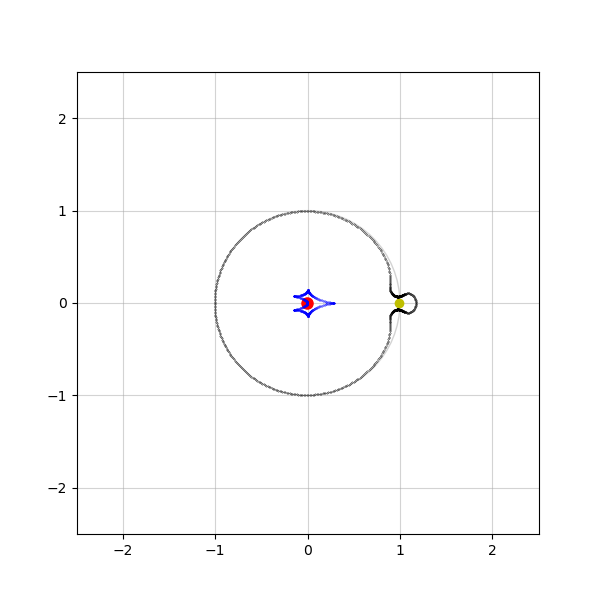

In [6]:
# s and q interactive slider plot
# VBBL setup
VBBL = vbl.VBBinaryLensing()
a1 = 0.5  # limb-darkening
VBBL.RelTol = 1e-03
VBBL.a1 = a1

def iterate_from(item):
    while item is not None:
        yield item
        item = item.next

def get_curves(s: float, q: float, VBBL: vbl.VBBinaryLensing) -> tuple:
    '''
    Returns the critical and caustic curves for a given s and q, using a VBBL object.

    Parameters:
    -----------
    s : float
        The separation between the two lens components.
    q : float
        The mass ratio of the two lens components.
    VBBL : VBBinaryLensing object
        The VBBinaryLensing object used to calculate the critical and caustic curves.

    Returns:
    --------
    critical_curves : numpy.ndarray
        The critical curves for the given s and q.
    caustic_curves : numpy.ndarray
        The caustic curves for the given s and q.
    '''
    solutions = VBBL.PlotCrit(s, q) # Returns _sols object containing n crit. curves followed by n caustic curves

    curves = []
    for curve in iterate_from(solutions.first):
        for point in iterate_from(curve.first):
            curves.append((point.x1, point.x2))
            
    critical_curves = np.array(curves[:int(len(curves)/2)])
    caustic_curves = np.array(curves[int(len(curves)/2):])

    return critical_curves, caustic_curves


%matplotlib widget

# Create the figure and axis globally so they are not recreated each time
plt.close(1)  # Close the previous figure, if it exists
plt.figure(figsize=(6, 6), num=1)
fig = plt.gcf()
ax = plt.gca()

# Add a grid
ax.grid(True, color='darkgrey', alpha=0.5)

# Set axis to be equal
ax.set_aspect('equal', adjustable='box')

# Set axis limits
ax.set_xlim(-1.5, 1.5)
ax.set_ylim(-1.5,  1.5)

# Update the plot without making a new figure
fig.canvas.draw()

def update_plot(logs_slider_value, logq_slider_value):

    s, q = 10.0**logs_slider_value, 10.0**logq_slider_value

    mtot = 100000000.0  # total scale mass (m1 + m2 = mtot)
    # q = m2/m1  # mass ratio
    # q*m1 = m2  # secondary lens mass
    # m1 +q*m1 = mtot
    # m1 * (1 + q) = mtot
    m1 = mtot/(1.0+q)  # primary lens mass
    m2 = mtot - m1  # secondary lens mass

    # Clear the previous plot content but keep the figure and axis
    ax.cla()  # Clear only the current axes

    # Plot the circles
    circle = Circle((0, 0), 1.0, edgecolor='darkgrey', facecolor='none', 
                    alpha=0.5, label=r'$\theta_E$')
    ax.add_patch(circle)

    # plot lens masses

    ax.plot(s*m1/mtot, 0, 'yo', markersize=np.log10(m2))  # primary lens
    ax.plot(-s*m2/mtot, 0, 'ro', markersize=np.log10(m1))  # secondary lens
    # center of mass is at the origin

    # add your code here:
    critical_curves, caustic_curves = get_curves(s, q, VBBL)
    plt.plot(critical_curves[:, 0], critical_curves[:, 1], 'k.', markersize=0.5)
    plt.plot(caustic_curves[:, 0], caustic_curves[:, 1], 'b.', markersize=0.5)
    #

    # Add a grid
    ax.grid(True, color='darkgrey', alpha=0.5)

    # Set axis to be equal
    ax.set_aspect('equal', adjustable='box') 

    # Set axis limits
    ax.set_xlim(-2.5, 2.5)
    ax.set_ylim(-2.5, 2.5)   

    # Update the plot without making a new figure
    fig.canvas.draw()

# Create interactive sliders and text boxes for s and q
slider_style = {'description_width': '150px'}  # Set the width of the description textboxes
slider_layout = widgets.Layout(width='500px')  # Set the width of the slider bars

logs0, logq0 = 0.0, -2.0  # Initial values for s and q
logsmin, logsmax = -5.0, np.log10(2.0)  # Minimum and maximum values for s
logqmin, logqmax = -3.0, 0.0  # Minimum and maximum values for q

logs_slider = widgets.FloatSlider(value=logs0, min=logsmin, max=logsmax, step=0.1, description='s', 
                               style=slider_style, layout=slider_layout, readout=False)
s_text = widgets.FloatText(value=10.0**logs0)

logq_slider = widgets.FloatSlider(value=logq0, min=logqmin, max=logqmax, step=0.1, description='q', 
                                style=slider_style, layout=slider_layout, readout=False)
q_text = widgets.FloatText(value=10.0**logq0)

# Define the custom transformation function
def update_s_text(change):
    s_text.value = 10.0 ** change['new']
def update_q_text(change):
    q_text.value = 10.0 ** change['new']

def update_logs_slider(change):
    logs_slider.value = np.log10(change['new'])
def update_logq_slider(change):
    logq_slider.value = np.log10(change['new'])

# Link the slider to the text widget using the custom function
logs_slider.observe(update_s_text, names='value')
logq_slider.observe(update_q_text, names='value')

# Link the text widget to the slider using the custom function
s_text.observe(update_logs_slider, names='value')
q_text.observe(update_logq_slider, names='value')

# Add observers to update the plot when the text widgets change
s_text.observe(lambda change: update_plot(logs_slider.value, logq_slider.value), names='value')
q_text.observe(lambda change: update_plot(logs_slider.value, logq_slider.value), names='value')

# Display sliders and text boxes
display(widgets.HBox([logs_slider, s_text]))
display(widgets.HBox([logq_slider, q_text]))

# Initial plot
update_plot(logs_slider.value, logq_slider.value)

Binary lens models have caustic geometries with outer "planetary" and inner "central" caustic curves where the magnification is formally infinite. In events with lens object separation is around $\theta_{\rm E}$ (i.e., $s=1$), these caustics merge into a single caustic, known as a "resonant caustic." Examples of these different caustic presentations are given in Figure x. The approximate boundaries for where these merged caustics become effectively separate are shown in Figure x. 

<style>
    table {
        margin-left: auto;
        margin-right: auto;
        width: 50%;
        text-align: center;
    }
</style>

| ![resonantregions](./Assets/Resonant_regions.png) |
| :-: |
| Figure x: Regions of differing caustic arrangements. These can also be considered the close-, intermediate-, and wide- separation regions (from left to right). This diagram is on the same scale as Figure~\ref{Method-F:sqGrid}. |

Unlike the single lens events, the Einstein ring is not the ring around which the lensed images are produced but is instead a mathematical construct used to give a relative scale to the model. In the binary lens system, images form around critical curves in the image plane, which envelope the lens masses. To find the critical image positions one can parametrically solve, for $\phi=[0,2\pi)$.
$$\sum_i^{N_l}\frac{\epsilon_i}{(\bar{z}-\bar{z}_{m,i})^2}=e^{i\phi}. $$
Figure x also shows examples of critical curves for different lens pairs (i.e., varied $s$ and $q$). 

The 2L1S model is much more complicated to parameterise than the single lens models. The binary lens model is parameterised by $(s,q,u_0,\alpha,t_0,t_{\rm E})$, where 
* $s$ describes the angular separation of the two lens masses in units of $\theta_{\rm E}$; 
* $q$ describes the mass ratio of the lens objects; 
* $u_0$ is the closest line-of-sight point of approach to the lens centre-of-mass made by the source in its relative trajectory; and 
* $t_0$ is the time at which this happens ($||{u(t_0)}||=u_0$, where $u(t_i)$ is the position of the source at a given time, $t$); 
* $\alpha$ is the angle of the source's trajectory relative to an axis that passes through both the fixed lens masses; and 
* $t_{\rm E}$ is the Einstein ring crossing time (the time the source takes to travel an angular distance of $\theta_{\rm E}$).  

A depiction of these parameters is shown in Figure x.

> $\rho$ is also included in this figure and it describes the apparent source radius in units of $\theta_{\rm E}$ and is a higher-order effect that is usually well constrained in binary lens events with caustic crossings.

<style>
    table {
        margin-left: auto;
        margin-right: auto;
        width: 75%;
        text-align: center;
    }
</style>

| ![magmap](./Assets/mag_map_and_params.png) |
| :-: |
|Figure x: Magnification map for $s=1$, $q=0.4$ with binary lens modelling parameters depicted. The single, large, resonant caustic structure is apparent between the lens object positions (red dots with sizes corresponding to their relative $\log_{10}m$). |

A simulated binary lens magnification map, for a fixed $s$ and $q$, can be seen in the background of Figure x. The source positions $(u_1, u_2)$ resulting in the greatest magnification ($A$) are those closest to, or crossing, the caustics. This kind of map represents the magnification you would observe with a point source. A binary lens magnification curve can be produced for a specific set of parameters of the binary lens model, by interpolating a "source trajectory" across a magnification map. The result of performing one of these trajectory interpolations is demonstrated in Figure 1. The various tools used for these calculations are discussed . A magnification model, $A(t)$, with binary lens model parameters, $\Theta$, can be fit to a data set with epochs, $t$, using the same linear regression process described in [Single Lenses](SingleLens.ipynb) and [Modelling](Modelling.ipynb). 

<style>
    table {
        margin-left: auto;
        margin-right: auto;
        width: 95%;
        text-align: center;
    }
</style>

| ![fsbltraj](./Assets/binary_trajectories_FS.png) |
| :-: |
| Figure 1: *Left:* Example caustic (blue) diagram, showing set of trajectories (purple) with varying $u_0$. The lens object positions are plotted as red, filled circles, where their relative sizes relate to their relative log mass ($\log_{10}m$). The centre of mass is indicated by the black "+"s'. The scale of the caustic diagram is in units of $\theta_{\rm E}$. The angular source size ($\rho=0.05$) and relative trajectory direction (where $\alpha=\pi/2$) are indicated by the circle and arrow on the trajectory lines, respectively. *Right:* Corresponding magnification curves, given the trajectories shown on the caustic diagram (*left*). |

Beyond short-cuts to interpreting the physical underpinnings of microlensing events, the collective experiences of the community also teach us about common degeneracies that indicate possibly viable arrangements, which may otherwise have been missed (see [Tsapras, 2018]() and references therein). Three of theses degeneracies are described here.

1. The geometry of lensing produces a fourfold degeneracy for parallax events (Gould, 1994), detailed in the [Higher Order](HigherOrder.ipynb) notebook. 
1. There is a well-known degeneracy between close- and wide-separation binary lenses (Dominik, 1999), but which should really be called inner and outer degenerate separations according to \cite{G23}.
    + This degeneracy is demonstrated in the $(s,q)$ grid searches, such as the one shown in Figure 2. This occurs because large-$q$ close solutions and smaller-q wide solutions can create similar magnifications curves, provided the other microlensing parameters are free. This similarity in magnification space is demonstrated in the caustics diagrams of a large-$q$, close-$s$ lenses and smaller-$q$, wide-$s$ lenses, in Figure x. 
1. More recently, a degeneracy was found to exist for "bump events" (Ryu et al., 2022), named the "central-resonant" degeneracy (Yang et al., 2022), such as the one in OGLE-2016-BLG-1195 (Gould, 2023).

> "Close" is used to refer to $s<\theta_{\rm E}$ ($\log_{10} s<0$), and "wide" to $s>\theta_{\rm E}$ ($\log_{10} s >0$). 

<style>
    table {
        margin-left: auto;
        margin-right: auto;
        width: 60%;
        text-align: center;
    }
</style>

| ![gridsearch](./Assets/chi2_map.png) |
| :-: |
| Figure 2: Grid Search over $s$ and $q$, with discretely searched $\rho$ values and the remaining microlensing parameters explored freely, for event OGLE-2017-BLG-1038. The $\chi^2$ values shown represent the best-fit value for the fixed $s$ and $q$; the $\rho$ dimension has been collapsed to its best-fit value. |

<style>
    table {
        margin-left: auto;
        margin-right: auto;
        width: 95%;
        text-align: center;
    }
</style>

| ![closewide](./Assets/close_wide_degeneracy.png) |
| :-: |
| Caustic diagrams demonstrating the potential for similar magnification curves for trajectories around caustics of large-q, close-s lenses (e.g. *left*) and smaller-q, wide-s lenses (e.g. *right*). For these diagrams, the caustics are shown in blue and critical curves in black. The origin is the centre of mass between lens masses. The mid-point is indicated by the black "+"s'. Lens body positions are shown as red, filled circles, where their relative sizes relate to their relative log mass ($\log_{10}m$), The zoomed in portions of the diagrams have the same scale and the axis are in units of $\theta_{\rm E}$.|

The 1L2S models are often degenerate with 2L1S, without observed caustic crossings. For example, the binary-source model shown in Figure~\ref{Method-F:BinarySourceLC} has a degenerate binary lens model (reproduced here as Figure~\ref{Method-F:J17-F3}). The situational importance of this degeneracy is explained in \cite{Gaudi1998}. It is only through thorough modelling investigations that we can determine which model is most likely and by what degree of significance. 

|  ![jung2017f3](./Assets/F3.png) |
| :-: |
| Reproduction of Jung et al (2017), Figure 3: Geometry and lightcurve of the [binary lens] model. *Top:* The upper panel shows the geometry of the [binary lens] model. The straight line with an arrow is the source trajectory, red closed concave curves represent the caustics, and blue filled circles (marked by $M_1$ and $M_2$) are the [binary lens] components. All length scales are normalised by the Einstein radius. The inset shows the general view and the major panel shows the enlarged view corresponding to the lightcurve of the lower panel. The open circle on the source trajectory is the source position at the time of observation whose size represents the source size. *Bottom:* The lower panel shows the enlarged view of the anomaly region. The inset shows a zoom of the lightcurve near $\rm{HJD}'\sim7501.4$. The curve superposed on the data is the best-fit [binary-lens] model. |

## Nest Steps

Oh hey, you're finished! Well done. That was huge.

If you haven't already, you should check out these notebooks:

* [Binary Sources](BinarySource.ipynb), and
* [Modelling](Modelling.ipynb) (expanded in dev).

Otherwise, a good option to takcle next would be:

[Higher-Order Effects]() (in preperation).